# 1. Refresher about unsupervised learning

**Unsupervised Learning** aims at finding structures inside a dataset. Usually, it implies to model the underlying probability distribution of the data $\rho(x)$. 

Examples of tasks in this category are:
- Clustering: group samples based on some similarity measure,
- Dimensionality reduction: Find a low-dimensional representation of high-dimensional data,
- Generative modelling: Generate samples from the unkown law $\rho(x)$,
- Also: Density estimation, representation learning, sampling, etc.

Compared to supervised learning, unsupervised learning has does not exploit **labels**, the dataset consists in $n$ **training samples** $\{x_i\}_{i=1}^n$, where $x_i \in \mathbb{R}^d$ (think of a feature vector, an image, a sound, etc.).

In this notebook, we are focusing on one of the simplest algorithm to perform **clustering**: the K-means.

# 2. K-means principle

In K-means, we assume the dataset is split into $K$ clusters, each having a center $\mu_k$ to which are assigned the datapoints falling the closest to $\mu_k$ (in Euclidean distance). Mathematically, the K-means cost reads
$$
R(X, \bm{C}, \mu) = \sum_{k=1}^K \sum_{i\in C_k} \lVert x_i - \mu_k \rVert_2^2,
$$
where
$$
\mu_k = \frac{1}{\lvert C_k\rvert}\sum_{i\in C_k} x_i.
$$

Minimizing the cost function jointly over the cluster centers $\mu_k$ for each $k$ and the assignments $\bm{C}$ is a hard nonconvex and combinatorial task. But remark that it is in fact easy to solve if we have access to a given clustering $\bm{C}$, meaning we know which $x_i$ belongs to class $k$. In this case, we just have to compute the barycenter of each cluster to get the centers $\{\mu_k\}_{k=1}^K$. Alternatively, if we have center of clusters, then the assignment is trivially given by nearest center to a training point.

With this simple reasoning, we drew the **natural K-Means algorithm** that we will implement which reads:
1. Initialize centers $\mu_1, \ldots, \mu_K$ randomly in $\mathbb{R}^d$,
2. Repeat until convergence:
    1. Compute, for each training point $x_i$, the *assignment* $a_i = \text{argmin}_k \lVert x_i - \mu_k \rVert_2^2$,
    2. Compute, for each cluster $k$, the *center* $\mu_k = \frac{1}{\lvert C_k\rvert}\sum_{i\in C_k} x_i$.

The cell below just loads some packages we will need to implement the algorithm and visuals the results.

In [1]:
from sklearn.datasets import make_moons           # Contains some dataset we will be using
from sklearn.cluster import KMeans                # Contains an implementation of the K-Means
from sklearn.preprocessing import StandardScaler  # Allows to standardize the features
import matplotlib.pyplot as plt                   # Used for plotting
import numpy as np                                # Used for handling linear algebra on vectors/arrays
from PIL import Image                             # Used to load JPEG images
from tqdm import tqdm                             # Used to display progress bars 
import matplotlib as mpl

# Formatting the plots
plt.rcParams['figure.figsize'] = [6,6]
plt.rcParams['font.size'] = 18
plt.rcParams['font.weight'] = 'normal'
plt.style.use('default')
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['mathtext.rm'] = 'serif'
mpl.rcParams['font.size'] = 22
mpl.rcParams['axes.formatter.limits'] = (-6, 6)
mpl.rcParams['axes.formatter.use_mathtext'] = True
mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
mpl.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
mpl.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.minor.visible'] = True

!git clone https://github.com/mlelarge/ens-ml4sd.git

Clonage dans 'ens-ml4sd'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 27 (delta 10), reused 14 (delta 3), pack-reused 0 (from 0)
Réception d'objets: 100% (27/27), 1.88 Mio | 3.88 Mio/s, fait.
Résolution des deltas: 100% (10/10), fait.


# 3. Data: a simple clustering problem

To understand and implement the algorithm, let us consider a synthetic dataset made of $n=300$ datapoints coming from three well-separated two-dimensional Gaussian clusters.

Text(0, 0.5, 'Feature 2')

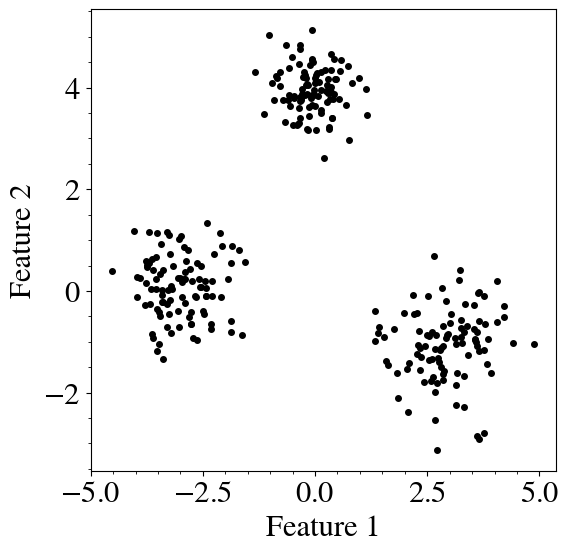

In [2]:
rng = np.random.RandomState(0)
l1 = [-3, 0]; l2 = [0, 4]; l3 = [3, -1]
A = rng.normal(loc=l1, scale=0.6, size=(100,2))
B = rng.normal(loc=l2, scale=0.5, size=(100,2))
C = rng.normal(loc=l3, scale=0.7, size=(100,2))
X = np.vstack([A,B,C])

fig, ax = plt.subplots(figsize=(6,6))
plt.plot(X[:,0], X[:,1], 'k.', markersize=8)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

> **Q1.** With this simple example, we have the chance to fully visualize the dataset. What number of clusters $K$ would you choose to run the algorithm?

This choice is not trivial in practical applications as the datasets are often both high-dimensional and not well separated.

# 4. Implementing K-means in Python

To implement the algorithm, we will follow a matrix convention where we store all the training points in line and each column correspond to a feature. Mathematically, we call $X \in \mathbb{R}^{n\times d}$ the feature matrix. For centers, we will also write $M \in \mathbb{R}^{K\times d}$.

 Below is a function allowing to compute the distance between each $x_i$ and each $\mu_k$. It returns a squared distance matrix $D \in \mathbb{R}^{n\times K}$.

In [3]:
def compute_distances(X, centers):
    """
    Compute squared Euclidean distances between each row of X and each center.
    X : (n, d) numpy array
    centers : (K, d) numpy array
    returns d2 : (n, K) numpy array of distances between x_i and center_j
    """
    n, d = X.shape
    K = centers.shape[0]
    d2 = np.zeros((n, K), dtype=float)
    for j in range(K):      # For each cluster j
        diff = X - centers[j]                   # Shape (n, d) : subtract center j from all points
        d2[:, j] = np.sum(diff**2, axis=1)      # Squared Euclidean distance
    return d2

A better-use of the power of the `numpy` library is to use **broadcasting** to compute the distances. Broadcasting is a way to perform elementwise operations on arrays of different shapes without having to replicate the matrices or a `for` loop. Here is a simple example of broadcasting in 2 dimensions.

In [4]:
A = np.array([[1, 2, 3],
              [4, 5, 6]])   # shape (2,3)

b = np.array([10, 20, 30])  # shape (3,)

C = A + b   # shape (2,3), b is broadcast across rows
print(C)

[[11 22 33]
 [14 25 36]]


Remark how $b$ is added to each row of $A$ without explicitly mentionning it. Below we rewrite the `compute_distances`function using this trick.

In [ ]:
def compute_distances(X, centers):
    """
    Compute squared Euclidean distances between each row of X and each center using broadcasting.
    X : (n, d) numpy array
    centers : (K, d) numpy array
    returns d2 : (n, K) numpy array of distances between x_i and center_j
    """
    # Use broadcasting to compute all distances at once
    diff = X[:, np.newaxis, :] - centers[np.newaxis, :, :]  # Shape: (n, K, d)
    return np.sum(diff**2, axis=2)  # Shape: (n, K)

> **Q2.** Based on this distance function, complete the following code to assign the different labels.

In [6]:
def assign_labels(X, centers):
    '''
    X : (n, d) numpy array
    centers : (K, d) numpy array
    returns assignments : (n,) numpy array of cluster indices
    '''
    distances = compute_distances(X, centers)       # Compute distances
    assignments = np.argmin(distances, axis=1)      # Assign to closest center
    return assignments

> **Q3.** Similarly, complete the following code to compute the new centers given a set of estimated labels.

In [ ]:
def compute_centers(X, labels, K):
    '''
    X : (n, d) numpy array
    labels : (n,) numpy array of cluster indices
    K : number of clusters
    returns centers : (K, d) numpy array of new center positions
    '''
    # YOUR CODE HERE
    n, d = X.shape
    centers = np.zeros((K, d), dtype=float)
    for k in range(K):
        members = X[labels == k]            # Extract the submatrix of X that have labels k. It is a matrix of size (|C_k|, d)
        centers[k] = members.mean(axis=0)   # Compute the mean of each column of this submatrix. It is a vector of size d
    return centers

> **Q4.** Now complete the function to compute the cost $R(X, M)$ of a given assignment.

In [ ]:
def compute_cost(X, centers, labels):
    '''
    X : (n, d) numpy array
    centers : (K, d) numpy array
    labels : (n,) numpy array of cluster indices
    returns cost : float, the K-Means cost function evaluated on X with given centers and labels
    '''
    # YOUR CODE HERE
    centers_per_datapoint = centers[labels]         # Shape (n, d): for each point, get the center it is assigned to
    cost = np.sum((X - centers_per_datapoint)**2)   # Compute the sum of squared distances between each point and its assigned center
    return cost

Now we just need to put it all together.

> **Q5.** Complete the function below to implement the K-Means algorithm using our previous codes.

In [ ]:
def kmeans_numpy(X, K, N_iters=100, seed=None):
    """
    X : (n, d) numpy array of data points
    K : number of clusters
    N_iters : maximum number of iterations
    seed : random seed for reproducibility
    returns centers_history : (N_iters+1, K, d) numpy array of centers over iterations
            labels : (n,) numpy array of final cluster assignments
            cost_history : list of costs over iterations
            final_cost : final cost value
    """
    rng = np.random.RandomState(seed)
    X = np.asarray(X, dtype=float)
    n, d = X.shape

    # --- Initialization (random training points) ---
    initial_idx = rng.choice(n, size=K, replace=False)
    centers = X[initial_idx].copy()

    # --- Storing vectors ---
    centers_history = [centers.copy()]
    labels = np.zeros(n, dtype=int)
    cost_history = []

    # --- Training loop ---
    for it in tqdm(range(N_iters)):       # Loop for a maximum of N_iters iterations
        # -----------------------
        # ----> YOUR CODE HERE
        # -----------------------
        # 1) Compute the assignments and cost
        assignments = assign_labels(X, centers)             # Compute the assignments for each datapoint
        cost = compute_cost(X, centers, assignments)        # Compute the cost for that assignment

        # 2) Compute the new centers
        new_centers = compute_centers(X, assignments, K)    # Compute new center positions
        
        # 3) Update for the next iteration
        centers = new_centers                                # Update centers
        labels = assignments                                 # Update labels
        
        # Store history
        cost_history.append(cost)                            # Store the cost
        centers_history.append(new_centers.copy())           # Store the center positions

    # Final cost computation
    final_cost = compute_cost(X, centers, labels)
    cost_history.append(final_cost)
    
    return np.array(centers_history), labels, cost_history

> **Q6.** It's time to train our algorithm! Call the `kmeans_numpy` with a value of $K=3$, for 10 iterations and with `seed=15`.

In [10]:
# YOUR CODE HERE
K = 3
centers_history, labels, cost_history = kmeans_numpy(X, K=K, N_iters=10, seed=15)

100%|██████████| 10/10 [00:00<00:00, 3237.59it/s]


> **Q7.** Below we plot the several estimated centers during training. Vary $K$ and the seed for intialization. Comment your findings.

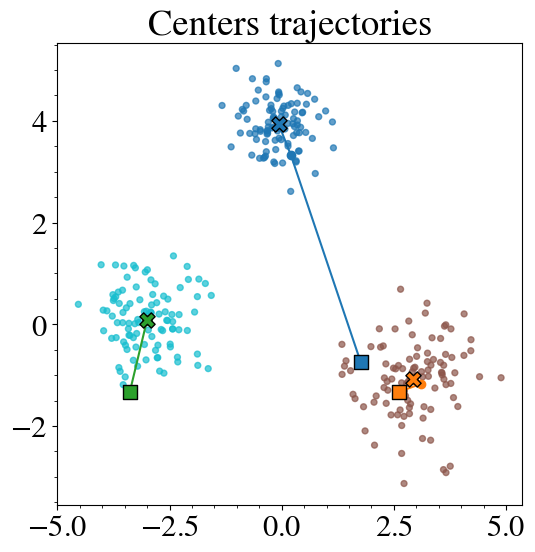

In [11]:
# Plotting the centers together with the training points
plt.figure(figsize=(6,6))
plt.scatter(X[:,0], X[:,1], c=labels, cmap='tab10', s=18, alpha=0.7)
cmap = plt.get_cmap('tab10')
for j in range(K):
    traj = centers_history[:, j, :]
    plt.plot(traj[:,0], traj[:,1], marker='o', linestyle='-', color=cmap(j))
    plt.scatter(traj[0,0], traj[0,1], marker='s', s=90, edgecolor='k', facecolor=cmap(j), zorder=5)
    plt.scatter(traj[-1,0], traj[-1,1], marker='X', s=120, edgecolor='k', facecolor=cmap(j), zorder=6)
plt.title("Centers trajectories")
plt.show()

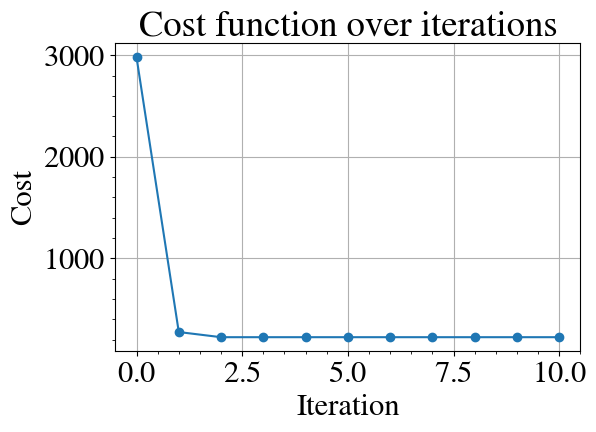

In [12]:
# Plot the cost function
plt.figure(figsize=(6,4))
plt.plot(cost_history, marker='o')
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Cost function over iterations")
plt.grid()
plt.show()

# 5. Scikit-learn's K-Means

In fact, everything we implemented is done in a well-known machine learning library called [`scikit-learn`](https://scikit-learn.org/stable/modules/clustering.html#clustering). It implements much more than the K-Means algorithm as shown in the 

> **Q8.** Use the `KMeans` class from `sklearn.cluster` to fit the same dataset with the same $K$ and number of iterations. Compare the results with your implementation. You can access the cluster centers with the attribute `cluster_centers_` and the labels with `labels_`.

/opt/anaconda3/envs/PR/lib/python3.9/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
100%|██████████| 10/10 [00:00<00:00, 4056.78it/s]


Text(0.5, 1.0, 'Ours')

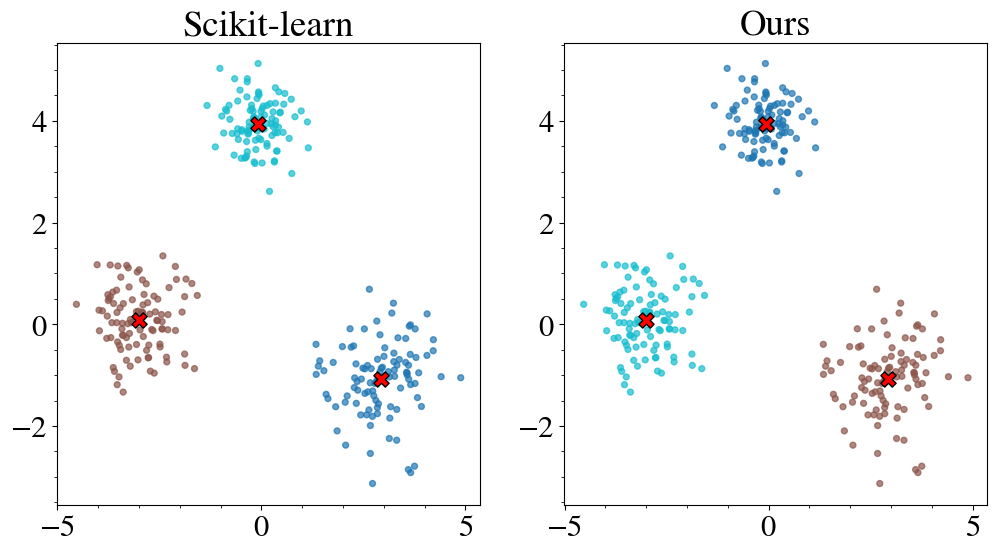

In [13]:
# YOUR CODE HERE
seed = 15
K = 3
kmeans = KMeans(n_clusters=K, n_init=10, max_iter=100, random_state=seed) # Create an instance of KMeans model with $K=3$
kmeans.fit(X)                               # Train the model on X
labels_sklearn = kmeans.labels_             # Returns the labels
centers_sklearn = kmeans.cluster_centers_   # Returns the centers

# Our implementation
centers_history, labels, cost_history = kmeans_numpy(X, K=K, N_iters=10, seed=seed)

# ---------------
# Plot function
# ---------------
def plot_kmeans(X, labels, centers, ax):
    ax.scatter(X[:,0], X[:,1], c=labels, cmap='tab10', s=18, alpha=0.7)
    ax.scatter(centers[:,0], centers[:,1], marker='X', s=120, edgecolor='k', facecolor='r', zorder=6)

fig, ax = plt.subplots(1, 2, figsize=(12,6))
plot_kmeans(X, labels_sklearn, centers_sklearn, ax[0])
ax[0].set_title("Scikit-learn")

plot_kmeans(X, labels, centers_history[-1], ax[1])
ax[1].set_title("Ours")


> **Q9.** Vary the seeds in the code above. Do you observe the same problem in the scikit-learn method?


# 6. A case where K-means fails


> **Q10.** In which case(s) do you think K-means would fail to find proper clusters?

Consider the following dataset made of two moons.

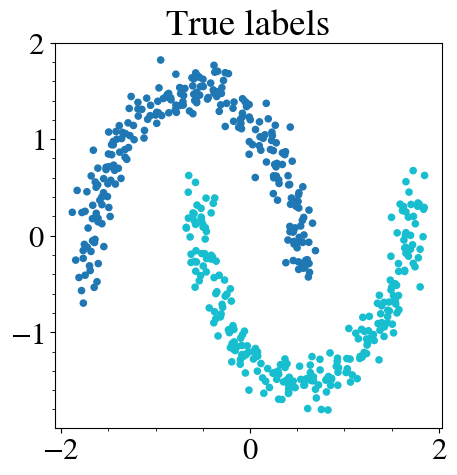

In [14]:
X_moons, y_moons = make_moons(n_samples=500, noise=0.07, random_state=42)
X_moons = StandardScaler().fit_transform(X_moons)

plt.figure(figsize=(5,5))
plt.title("True labels")
plt.scatter(X_moons[:,0], X_moons[:,1], c=y_moons, cmap='tab10', s=20)

> **Q11.** Apply the K-means algorithm to these data, show the clustering, and conclude.

100%|██████████| 10/10 [00:00<00:00, 4132.32it/s]


Text(0.5, 1.0, 'Ours')

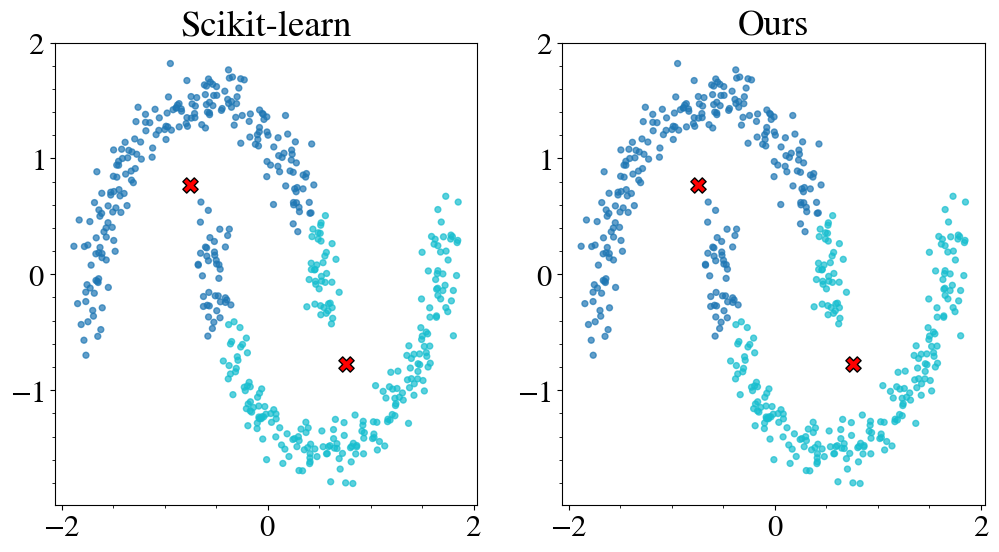

In [17]:
seed = 10
K = 2
kmeans = KMeans(n_clusters=K, n_init=10, max_iter=100, random_state=seed) # Create an instance of KMeans model with $K=3$
kmeans.fit(X_moons)                               # Train the model on X
labels_sklearn = kmeans.labels_             # Returns the labels
centers_sklearn = kmeans.cluster_centers_   # Returns the centers

# Our implementation
centers_history, labels, cost_history = kmeans_numpy(X_moons, K=K, N_iters=10, seed=seed)

fig, ax = plt.subplots(1, 2, figsize=(12,6))
plot_kmeans(X_moons, labels_sklearn, centers_sklearn, ax[0])
ax[0].set_title("Scikit-learn")

plot_kmeans(X_moons, labels, centers_history[-1], ax[1])
ax[1].set_title("Ours")


# 7. Image quantization

Image quantization is a task of reducing the number of distinct colours used to represent an image. Formally, we want to map each pixel value to a finite palette $\mathcal{P}={p_1, \ldots, p_K}_{k=1}^K$. The quantization look to minimize the distortion between the original and quantized image. We can view K-Means as a quantization algorithm where the number of clusters $K$ defines the size of the palette and the $p_k$ corresponds to the centers $\mu_k$ defined above.

> **Q12.** Vary the number of clusters $K$ in the code below to observe how the distortions evolve. Comment the case $K=2$: to what correspond the two classes visually, and why?

/opt/anaconda3/envs/PR/lib/python3.9/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


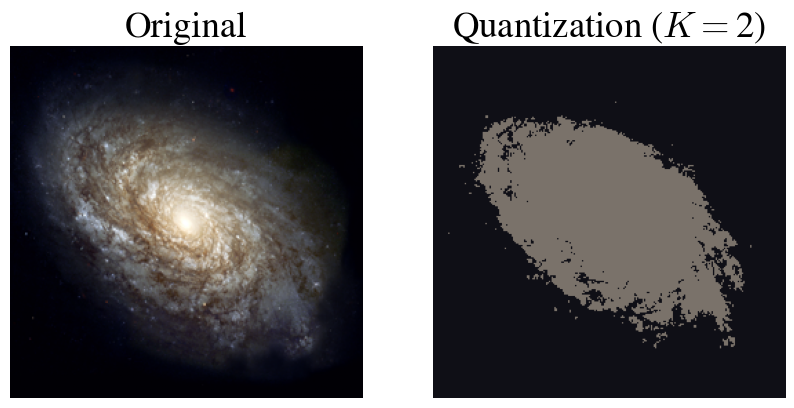

In [2]:
# Load the image in colab and open it
img = Image.open('./ens-ml4sd/notebooks/data/NGC4414.jpg').convert('RGB')
img = img.resize((256, 256))          # Resize the image to speed up
arr = np.array(img) / 255.0           # float [0,1], shape (H,W,3)
H, W, C = arr.shape
pixels = arr.reshape(-1, 3)

K = 2       # Number of K-means clusters

km = KMeans(n_clusters=K, n_init=10, random_state=42)
labels = km.fit_predict(pixels)
centers = km.cluster_centers_

# reconstruct compressed image
quant = centers[labels].reshape(H, W, 3)

# Plot the original image and the quantized one
plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.title('Original'); plt.imshow(arr); plt.axis('off')
plt.subplot(1,2,2); plt.title(r'Quantization ($K=${:d})'.format(K)); plt.imshow(quant); plt.axis('off')
plt.show()